In [8]:
import os
os.environ['TF_ENABLE_ONEDNN_OPTS'] = '0'

In [9]:
from ucimlrepo import fetch_ucirepo
from sklearn.model_selection import train_test_split
from sklearn.discriminant_analysis import StandardScaler
from sklearn.metrics import classification_report
from sklearn.preprocessing import StandardScaler
from tf_keras.models import Sequential
from tf_keras.layers import Dense, InputLayer
from sklearn.impute import SimpleImputer
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, roc_curve, auc, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# fetch dataset
heart_disease = fetch_ucirepo(id=45)

# extract data and target
X = heart_disease.data.features  # Features
y = heart_disease.data.targets   # Target variable

# targets that are 1-4, are now just equal to 1.
y = (y > 0).astype(int)

# select the 13 features (update these indices or column names based on the dataset)
selected_features = [
    "age", "sex", "cp", "trestbps", "chol", "fbs", "restecg",
    "thalach", "exang", "oldpeak", "slope", "ca", "thal"
]

# using only the selected features
X = X[selected_features]

# handle missing values by imputing them with the column mean
imputer = SimpleImputer(strategy='mean')
X = imputer.fit_transform(X)

In [10]:
# split dataset into 75% training and 25% testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

# this ensures that y_train and y_test are 1D
y_train = y_train.values.ravel()  # Convert to numpy array and flatten
y_test = y_test.values.ravel()

# standardize the data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [11]:
# build the ANN model
model = Sequential()
model.add(InputLayer(input_shape=(X_train_scaled.shape[1],)))
model.add(Dense(25, activation='relu'))
model.add(Dense(25, activation='relu'))
model.add(Dense(25, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.summary()

# Compile the model
model.compile(loss='binary_crossentropy', optimizer='sgd', metrics=['accuracy'])

# Train the model and capture the history
history = model.fit(X_train_scaled, y_train, validation_data=(X_test_scaled, y_test), epochs=100, batch_size=10)

# Make predictions
y_pred_prob = model.predict(X_test_scaled).ravel()  # Get the predicted probabilities
y_pred = (y_pred_prob > 0.5).astype("int32")  # Convert probabilities to binary predictions

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_4 (Dense)             (None, 25)                350       
                                                                 
 dense_5 (Dense)             (None, 25)                650       
                                                                 
 dense_6 (Dense)             (None, 25)                650       
                                                                 
 dense_7 (Dense)             (None, 1)                 26        
                                                                 
Total params: 1676 (6.55 KB)
Trainable params: 1676 (6.55 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/100
23/23 [==============================] - 0s 6ms/step - loss: 0.6599 - accuracy: 0.6035 - val_loss: 0.6470 - val_accuracy: 0.5921
Epoch 2/100
2

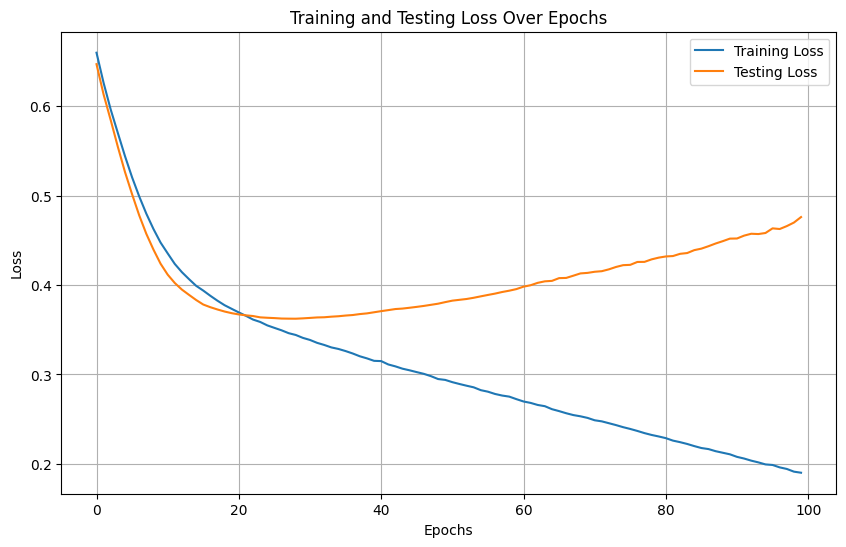

In [12]:
# Plot the training and testing loss over the epochs
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Testing Loss')
plt.title('Training and Testing Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

Precision: 0.84
Recall (Sensitivity): 0.86
Specificity: 0.85
F1-Score: 0.85


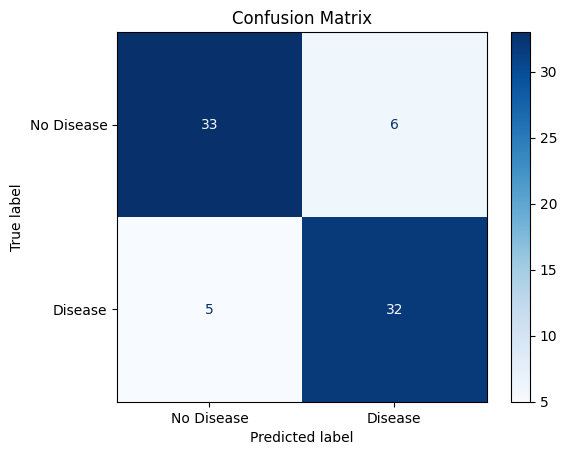

In [13]:
# calculate Precision, Recall, F1-Score
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

# TN, FP, FN, TP from the confusion matrix
tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()

# calculate Specificity
specificity = tn / (tn + fp)

# print all metrics
print(f"Precision: {precision:.2f}")
print(f"Recall (Sensitivity): {recall:.2f}")
print(f"Specificity: {specificity:.2f}")
print(f"F1-Score: {f1:.2f}")

# generate and display Confusion Matrix
ConfusionMatrixDisplay.from_predictions(y_test, y_pred, display_labels=["No Disease", "Disease"], cmap="Blues")
plt.title("Confusion Matrix")
plt.show()

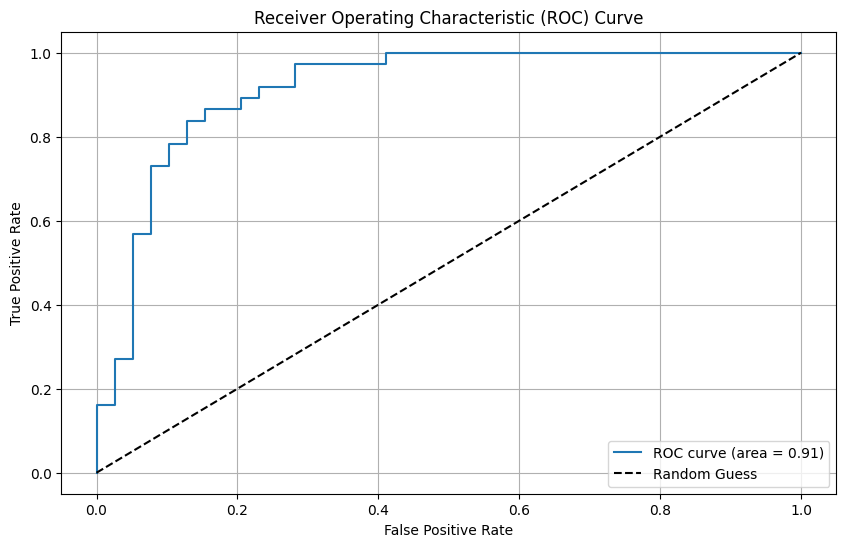

In [14]:
# Compute ROC curve and ROC area
fpr, tpr, _ = roc_curve(y_test, y_pred_prob)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], "k--", label="Random Guess")
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()